In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import itertools
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore") 

In [3]:
import prophet
from pandas import read_csv
from matplotlib import pyplot
from pandas import to_datetime
from prophet import Prophet
from pandas import DataFrame

In [4]:
pollution_data = pd.read_csv('pollution_2000_2021.csv')

In [5]:
pollution_data

,Date,Year,Month,Day,Address,State,County,City,O3 Mean,O3 1st Max Value,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
0,2000-01-01,2000,1,1,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.019765,0.040,...,23,25.0,3.000000,9.0,21,13.0,19.041667,49.0,19,46
1,2000-01-02,2000,1,2,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.032,...,0,26.0,1.958333,3.0,22,4.0,22.958333,36.0,19,34
2,2000-01-03,2000,1,3,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.009353,0.016,...,8,28.0,5.250000,11.0,19,16.0,38.125000,51.0,8,48
3,2000-01-04,2000,1,4,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.015882,0.033,...,23,34.0,7.083333,16.0,8,23.0,40.260870,74.0,8,72
4,2000-01-05,2000,1,5,1645 E ROOSEVELT ST-CENTRAL PHOENIX STN,Arizona,Maricopa,Phoenix,0.007353,0.012,...,2,42.0,8.708333,15.0,7,21.0,48.450000,61.0,22,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608694,2021-06-26,2021,6,26,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.040588,0.049,...,0,1.0,0.409091,0.7,2,0.0,1.281818,2.1,0,2
608695,2021-06-27,2021,6,27,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.037882,0.042,...,0,1.0,0.325000,0.4,4,0.0,1.104167,2.3,20,2
608696,2021-06-28,2021,6,28,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.039765,0.050,...,0,1.0,0.326087,0.5,2,0.0,1.678261,5.8,23,5
608697,2021-06-29,2021,6,29,NCore - North Cheyenne Soccer Complex,Wyoming,Laramie,Not in a city,0.049176,0.058,...,0,1.0,0.317391,0.5,20,0.0,2.934783,7.4,0,7


In [6]:
# filter to New York
pollution_data_ny = pollution_data[pollution_data['City'] == 'New York']

# filter to Date
pollution_data_ny= pollution_data_ny[pollution_data_ny['Date'] >= '2013-01-01']
pollution_data_ny['Date']= pd.to_datetime(pollution_data_ny['Date'])

pollution_data_ny.head()

,Date,Year,Month,Day,Address,State,County,City,O3 Mean,O3 1st Max Value,...,CO 1st Max Hour,CO AQI,SO2 Mean,SO2 1st Max Value,SO2 1st Max Hour,SO2 AQI,NO2 Mean,NO2 1st Max Value,NO2 1st Max Hour,NO2 AQI
357115,2013-01-01,2013,1,1,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.023824,0.026,...,5,7.0,5.408333,9.2,6,13.0,16.470833,22.2,6,21
357116,2013-01-02,2013,1,2,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.020471,0.023,...,7,6.0,6.045455,9.0,20,13.0,18.650000,27.8,8,25
357117,2013-01-03,2013,1,3,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.013059,0.021,...,9,7.0,6.687500,11.5,21,16.0,24.033333,36.0,19,34
357118,2013-01-04,2013,1,4,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.016588,0.021,...,6,7.0,7.762500,12.2,4,17.0,28.195833,39.3,7,37
357119,2013-01-05,2013,1,5,200TH STREET AND SOUTHERN BOULDVARD Pfizer Lab,New York,Bronx,New York,0.014647,0.027,...,21,9.0,7.004167,10.5,21,14.0,24.966667,44.1,20,42


In [7]:
df = pollution_data_ny

In [8]:
selected_columns = ['Date', 'O3 Mean']  # Replace 'column_name1' and 'column_name2' with the actual column names you want

# Create a new DataFrame with only the selected columns
df = df[selected_columns]
df

,Date,O3 Mean
357115,2013-01-01,0.023824
357116,2013-01-02,0.020471
357117,2013-01-03,0.013059
357118,2013-01-04,0.016588
357119,2013-01-05,0.014647
...,...,...
601802,2021-09-26,0.033294
601803,2021-09-27,0.043412
601804,2021-09-28,0.026714
601805,2021-09-29,0.023529


In [9]:
df.set_index('Date', inplace=True)

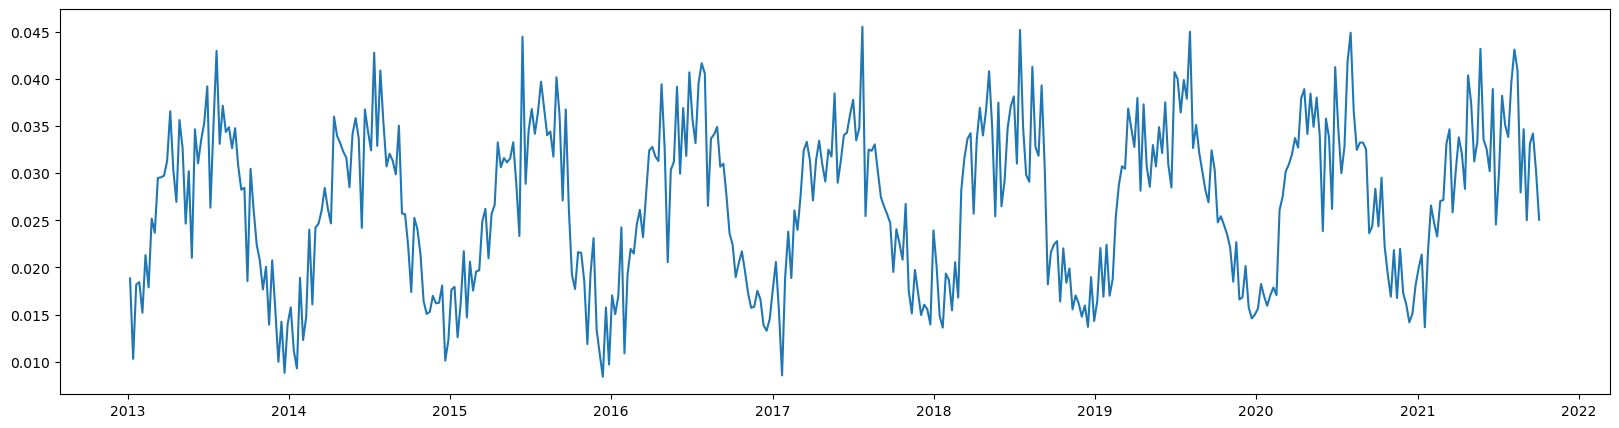

In [10]:
W = df.resample('W').mean() #df_O3.rolling(window=30).mean().dropna()
plt.figure(figsize=(20,5));
plt.plot(W)

In [11]:
W

,O3 Mean
Date,
2013-01-06,0.018833
2013-01-13,0.010307
2013-01-20,0.018197
2013-01-27,0.018437
2013-02-03,0.015201
...,...
2021-09-05,0.025011
2021-09-12,0.033112
2021-09-19,0.034222


In [44]:
W.columns = ['ds', 'y']

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [31]:
model = Prophet()
# fit the model
model.fit(df)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [11]:
future = list()
for i in range(1, 13):
 date = '2021-%02d' % i
 future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])

          ds      yhat  yhat_lower  yhat_upper
0 2021-01-01  0.018522    0.007863    0.029037
1 2021-02-01  0.020000    0.009571    0.030571
2 2021-03-01  0.028059    0.017457    0.037933
3 2021-04-01  0.032479    0.021788    0.043337
4 2021-05-01  0.035752    0.025710    0.046002


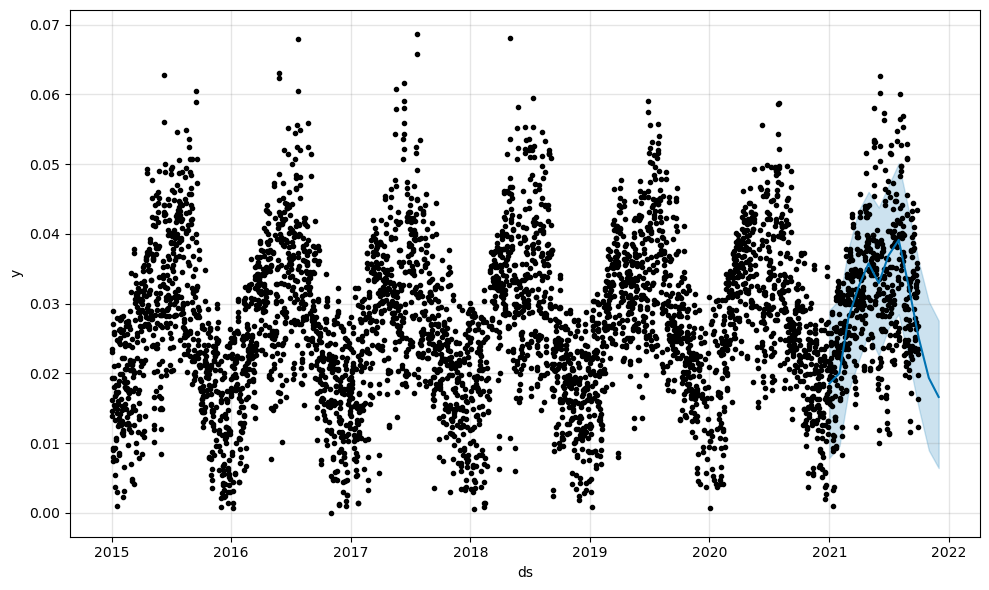

In [32]:
forecast = model.predict(future)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
model.plot(forecast)
pyplot.show()